# Strategy Details

### Code Author: Karl Ngan

Reference: Mathematical modeling and dynamic trading strategies for gold and bitcoin 


Link to reference: https://www.linkedin.com/posts/namnguyento_quantitativefinance-bitcoin-portfoliomanagement-activity-7173676442709377024-dIlp?utm_source=share&utm_medium=member_desktop

The main idea: Using the Holt-Winters model and the financial indicators to develop trading strategies on BTC and Gold market

In [141]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import pandas_ta as ta

start_date = '2019-01-01'
end_date = '2024-10-31'

In [142]:
def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start= start_date, end= end_date)

        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    df['date'] = df.index

    if len(df) == 0:
        os.remove(file_name)
        return None

    return df

In [143]:
#Downloading the data from Yahoo Finance
gold = load_data('GC=F')[['Open' , 'Close']]
btc = load_data('BTC-USD')[['Open' , 'Close']]
lookback = 60
#changing the dates format
gold['date'] = gold.index
btc['date'] = btc.index
gold['date'] = pd.to_datetime(gold['date'], format='%Y-%m-%d').dt.date
btc['date'] = pd.to_datetime(btc['date'], format='%Y-%m-%d').dt.date
gold.set_index('date', inplace=True)
btc.set_index('date', inplace=True)


In [144]:
#daily returns
gold['daily_return'] = gold['Close'].pct_change()
btc['daily_return'] = btc['Close'].pct_change()



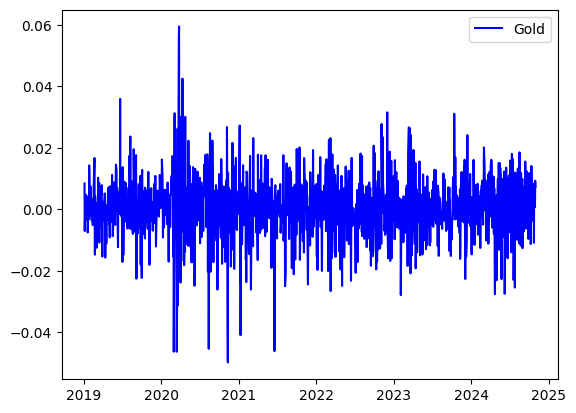

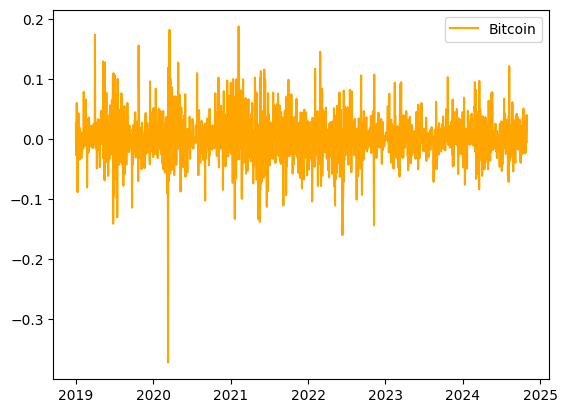

In [145]:
#plot the returns to see the data trend

plt.plot(gold['daily_return'], label='Gold', color='blue')
plt.legend()
plt.show()

plt.plot(btc['daily_return'], label='Bitcoin', color='orange')
plt.legend()
plt.show()

### Holt-Winters non-seasonal model


In [146]:
#define function for forecasting the price
def forecast_price(price):
    
    for i in range(len(price)):
        if i < lookback:
            continue

        #for the day i, we calculate the forecast value for the next day with pass 30 days data
        past_price = price['daily_return'].iloc[i-lookback:i]
        model = sm.tsa.ExponentialSmoothing(past_price, trend= "add", damped_trend=False).fit()
        
        #forecast the next day return
        price['forecast'].iloc[i] = model.forecast(steps=1)
        
    return price


In [147]:
#forecast the price for gold and bitcoin
#ignore warning
import warnings
warnings.filterwarnings("ignore")

gold['forecast'] = np.nan
gold = forecast_price(gold)

btc['forecast'] = np.nan
btc = forecast_price(btc)

In [148]:
#checking the accruacy of the forecast at least on the direction of the price
#create new dataframe to store the forecasted direction
gold_acc = gold.copy()
gold_acc['forecast_direction'] = np.nan
gold_acc['forecast_direction'].loc[gold['forecast'] > 0] = 1
gold_acc['forecast_direction'].loc[gold['forecast'] < 0] = -1

gold_acc['actual_direction'] = np.nan
gold_acc['actual_direction'].loc[gold['daily_return'] > 0] = 1
gold_acc['actual_direction'].loc[gold['daily_return'] < 0] = -1
gold_acc['actual_direction'] = gold_acc['actual_direction'].shift(-1)

gold_acc['correct'] = np.nan
gold_acc['correct'].loc[gold_acc['forecast_direction'] == gold_acc['actual_direction']] = 1
gold_acc['correct'].loc[gold_acc['forecast_direction'] != gold_acc['actual_direction']] = 0

gold_acc.dropna(inplace=True)

gold_acc['correct'].value_counts()





correct
1.0    732
0.0    667
Name: count, dtype: int64

In [149]:

btc_acc = btc.copy()
btc_acc['forecast_direction'] = np.nan
btc_acc['forecast_direction'].loc[btc['forecast'] > 0] = 1
btc_acc['forecast_direction'].loc[btc['forecast'] < 0] = -1

btc_acc['actual_direction'] = np.nan
btc_acc['actual_direction'].loc[btc['daily_return'] > 0] = 1
btc_acc['actual_direction'].loc[btc['daily_return'] < 0] = -1
btc_acc['actual_direction'] = btc_acc['actual_direction'].shift(-1)

btc_acc['correct'] = np.nan
btc_acc['correct'].loc[btc_acc['forecast_direction'] == btc_acc['actual_direction']] = 1
btc_acc['correct'].loc[btc_acc['forecast_direction'] != btc_acc['actual_direction']] = 0

#drop if forecast is nan
btc_acc.dropna(inplace=True)
btc_acc['correct'].value_counts()


correct
1.0    1081
0.0     987
Name: count, dtype: int64

In [150]:
#calculate the accuracy
print("Gold forecast accuracy: ", gold_acc['correct'].sum() / len(gold_acc))
print("Bitcoin forecast accuracy: ", btc_acc['correct'].sum() / len(btc_acc))

Gold forecast accuracy:  0.5232308791994281
Bitcoin forecast accuracy:  0.5227272727272727


 the forecast has around 50% accuracy rate only on both BTC and Gold prediction which is not ideal. It is beleive that the model fails as return is not stationary.
 
 But still, we may use this as reference and further develop new strategies based on it. 

## Trading Strategy 1 Overview:

If the predicted return is postive, we long in the next day, otherwise we short. No holding

In [151]:

#Gold Strategy 1
Gold_Strategy1_returns_holder = []
flag = 0#0 means no position, 1 means long, -1 means short
for i in range(len(gold)-1):
    if i < lookback:
        continue
    
    #if the forecasted price is higher than the current price, we buy
    if gold['forecast'].iloc[i] > 0:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0

        #using ith price to predict and make decision on i+1th price
        Gold_Strategy1_returns_holder.append(gold['daily_return'].iloc[i+1] - tx_cost)
    else:
        if  flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        Gold_Strategy1_returns_holder.append(-gold['daily_return'].iloc[i+1] - tx_cost)


Gold_Strategy1_Returns_df = pd.DataFrame(Gold_Strategy1_returns_holder)
Gold_Strategy1_Returns_df.columns = ['Gold_Strategy1_Returns']
Gold_Strategy1_Returns_df.index = gold.index[lookback+1:]


#BTC Strategy 1
BTC_Strategy1_returns_holder = []
flag = 0 
for i in range(len(btc)-1):
    if i < lookback:
        continue
    
    #if the forecasted price is higher than the current price, we buy
    if btc['forecast'].iloc[i] > 0:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0
        
        BTC_Strategy1_returns_holder.append(btc['daily_return'].iloc[i+1]*flag  - tx_cost)
            
    else:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        BTC_Strategy1_returns_holder.append(btc['daily_return'].iloc[i+1]*flag - tx_cost)

BTC_Strategy_Returns_df = pd.DataFrame(BTC_Strategy1_returns_holder)
BTC_Strategy_Returns_df.columns = ['BTC_Strategy1_Returns']
BTC_Strategy_Returns_df.index = btc.index[lookback+1:]


#Results    

results = pd.DataFrame(columns=['Mean', 'SD', 'Sharpe'])
results.loc['Gold_Strategy1'] = [Gold_Strategy1_Returns_df['Gold_Strategy1_Returns'].mean(), Gold_Strategy1_Returns_df['Gold_Strategy1_Returns'].std(), Gold_Strategy1_Returns_df['Gold_Strategy1_Returns'].mean()/Gold_Strategy1_Returns_df['Gold_Strategy1_Returns'].std()]
results.loc['BTC_Strategy1'] = [BTC_Strategy_Returns_df['BTC_Strategy1_Returns'].mean(), BTC_Strategy_Returns_df['BTC_Strategy1_Returns'].std(), BTC_Strategy_Returns_df['BTC_Strategy1_Returns'].mean()/BTC_Strategy_Returns_df['BTC_Strategy1_Returns'].std()]

print(results)

                    Mean        SD    Sharpe
Gold_Strategy1  0.000060  0.009893  0.006022
BTC_Strategy1   0.001955  0.034251  0.057091


### Refining Strategy 1 

Oberving the results from Strategy 1, it is not profitable mainly due to the transaction cost and the errors on model.

Taking this into account, we are going to further refine the result with more conditioners.

In [152]:
#Not to trade if the price difference is smaller than the transaction cost
#Gold Strategy 1.5
Gold_Strategy1_5_returns_holder = []
flag = 0#0 means no position, 1 means long, -1 means short

for i in range(len(gold)-1):
    if i < lookback:
        continue

    #if the forecasted price is higher than the current price and the tx cost, we buy
    if gold['forecast'].iloc[i] > 0.0025:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0

        Gold_Strategy1_5_returns_holder.append(gold['daily_return'].iloc[i+1]*flag - tx_cost)

    elif gold['forecast'].iloc[i] < -0.0025:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0

        Gold_Strategy1_5_returns_holder.append(gold['daily_return'].iloc[i+1]*flag - tx_cost)
    
    else:
        Gold_Strategy1_5_returns_holder.append(gold['daily_return'].iloc[i+1]*flag)
    
Gold_Strategy1_5_returns_df = pd.DataFrame(Gold_Strategy1_5_returns_holder)
Gold_Strategy1_5_returns_df.columns = ['Gold_Strategy1_5_Returns']
Gold_Strategy1_5_returns_df.index = gold.index[lookback+1:]


#BTC Strategy 1.5
BTC_Strategy1_5_returns_holder = []
flag = 0

for i in range(len(btc)-1):
    if i < lookback:
        continue

    #if the forecasted price is higher than the current price and the tx cost, we buy
    if btc['forecast'].iloc[i] > 0.0025 :
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0

        BTC_Strategy1_5_returns_holder.append(btc['daily_return'].iloc[i+1]*flag - tx_cost)

    elif btc['forecast'].iloc[i] < -0.0025:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0

        BTC_Strategy1_5_returns_holder.append(btc['daily_return'].iloc[i+1]*flag - tx_cost)
    
    else:
        BTC_Strategy1_5_returns_holder.append(btc['daily_return'].iloc[i+1]*flag)
BTC_Strategy1_5_returns_df = pd.DataFrame(BTC_Strategy1_5_returns_holder)
BTC_Strategy1_5_returns_df.columns = ['BTC_Strategy1_5_Returns']
BTC_Strategy1_5_returns_df.index = btc.index[lookback+1:]

#Results

results.loc['Gold_Strategy1_5'] = [Gold_Strategy1_5_returns_df['Gold_Strategy1_5_Returns'].mean(), Gold_Strategy1_5_returns_df['Gold_Strategy1_5_Returns'].std(), Gold_Strategy1_5_returns_df['Gold_Strategy1_5_Returns'].mean()/Gold_Strategy1_5_returns_df['Gold_Strategy1_5_Returns'].std()]
results.loc['BTC_Strategy1_5'] = [BTC_Strategy1_5_returns_df['BTC_Strategy1_5_Returns'].mean(), BTC_Strategy1_5_returns_df['BTC_Strategy1_5_Returns'].std(), BTC_Strategy1_5_returns_df['BTC_Strategy1_5_Returns'].mean()/BTC_Strategy1_5_returns_df['BTC_Strategy1_5_Returns'].std()]

print(results)

                      Mean        SD    Sharpe
Gold_Strategy1    0.000060  0.009893  0.006022
BTC_Strategy1     0.001955  0.034251  0.057091
Gold_Strategy1_5 -0.000086  0.009823 -0.008783
BTC_Strategy1_5   0.001581  0.034266  0.046125


### Comments on the strategy 1
The strategy are not profitable mainly due to model's errors triggering the excess frequent long-short and the transaction cost associated.
We may use the financial indicators as conditioner to generate better signals 


## Trading Strategy 2 Overview:

Calculating the SMA for gold and BTC. if they cross, we change the position of signals.

In [153]:
#SMA
gold['SMA'] = gold['Close'].rolling(window=65).mean()
btc['SMA'] = btc['Close'].rolling(window=30).mean()



#Gold Strategy 2
Gold_Strategy2_returns_holder = []
flag = 0#0 means no position, 1 means long, -1 means short

for i in range(len(gold)-1):
    if i < lookback:
        continue
    
    if gold['Close'].iloc[i] > gold['SMA'].iloc[i]:
        
        if flag != 1:
            if gold['forecast'].iloc[i] > 0.0025:
                tx_cost = 0.0025
                flag = 1
            else:
                tx_cost = 0
        else:
            tx_cost = 0

        Gold_Strategy2_returns_holder.append(gold['daily_return'].iloc[i+1]*flag - tx_cost)

    elif gold['Close'].iloc[i] < gold['SMA'].iloc[i]:
        if flag != -1:
            if gold['forecast'].iloc[i] < -0.0025:
                tx_cost = 0.0025
                flag = -1
            else:
                tx_cost = 0
        else:
            tx_cost = 0
        Gold_Strategy2_returns_holder.append(gold['daily_return'].iloc[i+1]*flag - tx_cost)
    else:
        Gold_Strategy2_returns_holder.append(gold['daily_return'].iloc[i+1]*flag)

Gold_Strategy2_Returns_df = pd.DataFrame(Gold_Strategy2_returns_holder)
Gold_Strategy2_Returns_df.columns = ['Gold_Strategy2_Returns']
Gold_Strategy2_Returns_df.index = gold.index[lookback+1:]

#BTC Strategy 2
BTC_Strategy2_returns_holder = []
flag = 0

for i in range(len(btc)-1):
    if i < lookback:
        continue
    
    if btc['Close'].iloc[i] > btc['SMA'].iloc[i]:
        if flag != 1:
            if btc['forecast'].iloc[i] > 0.0025: 
                tx_cost = 0.0025
                flag = 1
            else:
                tx_cost = 0
        else:
            tx_cost = 0

        BTC_Strategy2_returns_holder.append(btc['daily_return'].iloc[i+1]*flag - tx_cost)

    elif btc['Close'].iloc[i] < btc['SMA'].iloc[i]:
        if flag != -1:
            if btc['forecast'].iloc[i] < -0.0025:
                tx_cost = 0.0025
                flag = -1
            else:
                tx_cost = 0
        else:
            tx_cost = 0
        BTC_Strategy2_returns_holder.append(btc['daily_return'].iloc[i+1]*flag - tx_cost)


BTC_Strategy2_Returns_df = pd.DataFrame(BTC_Strategy2_returns_holder)
BTC_Strategy2_Returns_df.columns = ['BTC_Strategy2_Returns']
BTC_Strategy2_Returns_df.index = btc.index[lookback+1:]

#Results

results.loc['Gold_Strategy2'] = [Gold_Strategy2_Returns_df['Gold_Strategy2_Returns'].mean(), Gold_Strategy2_Returns_df['Gold_Strategy2_Returns'].std(), Gold_Strategy2_Returns_df['Gold_Strategy2_Returns'].mean()/Gold_Strategy2_Returns_df['Gold_Strategy2_Returns'].std()]
results.loc['BTC_Strategy2'] = [BTC_Strategy2_Returns_df['BTC_Strategy2_Returns'].mean(), BTC_Strategy2_Returns_df['BTC_Strategy2_Returns'].std(), BTC_Strategy2_Returns_df['BTC_Strategy2_Returns'].mean()/BTC_Strategy2_Returns_df['BTC_Strategy2_Returns'].std()]


print(results)


                      Mean        SD    Sharpe
Gold_Strategy1    0.000060  0.009893  0.006022
BTC_Strategy1     0.001955  0.034251  0.057091
Gold_Strategy1_5 -0.000086  0.009823 -0.008783
BTC_Strategy1_5   0.001581  0.034266  0.046125
Gold_Strategy2    0.000082  0.009826  0.008297
BTC_Strategy2     0.001254  0.034281  0.036568


### Comments on Strategy 2 
Using the finanical indicators Simple moving average, the results are better than the simple trading strategies above.

## Strategy 3 
Using and the predicted return and bollinger band to generate next day signals:







Strategy 3: considering the overbuying/overselling and the trend 

If price is larger than upperband, sell it

If price is smaller than upperband but larger than middleband, buy it

If price is smaller than middleband but larger than lowerband, sell it

If price is smaller than lowerband, buy it

 
 

When switching the position (i.e. the price crossed the band), we have implied additonal condition:

    the forecasted return to reverse the position is larger than the transaction cost required.


In [154]:
#getting the Bollinger Bands
gold[['bb_lower','bb_middle','bb_upper']] = ta.bbands(gold['Close'], length=30, std=2)[['BBL_30_2.0','BBM_30_2.0','BBU_30_2.0']]
btc[['bb_lower','bb_middle','bb_upper']] = ta.bbands(btc['Close'], length=30, std=2)[['BBL_30_2.0','BBM_30_2.0','BBU_30_2.0']]

In [155]:
#Gold Strategy 3
Gold_Strategy3_returns_holder = []
tx_cost = 0.0025
flag = 0 #0 means no position, 1 means long, -1 means short

for i in range(len(gold)-1):
    if i < lookback:
        continue
    
    if  gold['Close'].iloc[i] > gold['bb_upper'].iloc[i]:
        if flag != -1:
            if gold['forecast'].iloc[i] < -0.0025: 
                tx_cost = 0.0025
                flag = -1
            else:
                tx_cost = 0
        else:
            tx_cost = 0
        Gold_Strategy3_returns_holder.append(gold['daily_return'].iloc[i+1]*flag - tx_cost)

    elif (gold['Close'].iloc[i] > gold['bb_middle'].iloc[i]) and (gold['Close'].iloc[i] < gold['bb_upper'].iloc[i]):
        if flag != 1:
            if gold['forecast'].iloc[i] > 0.0025:
                tx_cost = 0.0025
                flag = 1
            else:
                tx_cost = 0
        else:
            tx_cost = 0
        Gold_Strategy3_returns_holder.append(gold['daily_return'].iloc[i+1]*flag - tx_cost)

    elif (gold['Close'].iloc[i] < gold['bb_middle'].iloc[i]) and (gold['Close'].iloc[i] > gold['bb_lower'].iloc[i]) :
        if flag != -1:
            if gold['forecast'].iloc[i] < -0.0025:
                tx_cost = 0.0025
                flag = -1
            else:
                tx_cost = 0
        else:
            tx_cost = 0
        Gold_Strategy3_returns_holder.append(gold['daily_return'].iloc[i+1]*flag - tx_cost)

    else:
        if flag != 1:
            if gold['forecast'].iloc[i] > 0.0025:
                tx_cost = 0.0025
                flag = 1
            else:
                tx_cost = 0
        else:
            tx_cost = 0
        Gold_Strategy3_returns_holder.append(gold['daily_return'].iloc[i+1]*flag - tx_cost)


Gold_Strategy3_Returns_df = pd.DataFrame(Gold_Strategy3_returns_holder)
Gold_Strategy3_Returns_df.columns = ['Gold_Strategy3_Returns']
Gold_Strategy3_Returns_df.index = gold.index[lookback+1:]


#BTC Strategy 3
BTC_Strategy3_returns_holder = []
tx_cost = 0.0025
flag = 0

for i in range(len(btc)-1):
    if i < lookback:
        continue

    if  btc['Close'].iloc[i] > btc['bb_upper'].iloc[i]:
        if flag != -1:
            if btc['forecast'].iloc[i] < -0.0025:
                tx_cost = 0.0025
                flag = -1
            else:
                tx_cost = 0
        else:
            tx_cost = 0
        BTC_Strategy3_returns_holder.append(-btc['daily_return'].iloc[i+1] - tx_cost)
    
    elif (btc['Close'].iloc[i] < btc['bb_upper'].iloc[i]) and (btc['Close'].iloc[i] > btc['bb_middle'].iloc[i]):
        if flag != 1:
            if btc['forecast'].iloc[i] > 0.0025:
                tx_cost = 0.0025
                flag = 1
            else:
                tx_cost = 0
        else:  
            tx_cost = 0
        BTC_Strategy3_returns_holder.append(btc['daily_return'].iloc[i+1]*flag - tx_cost)

    elif (btc['Close'].iloc[i] < btc['bb_middle'].iloc[i]) and (btc['Close'].iloc[i] > btc['bb_lower'].iloc[i]) :    
        if flag != -1:
            if btc['forecast'].iloc[i] < -0.0025:
                tx_cost = 0.0025
                flag = -1
            else:
                tx_cost = 0
        else:
            tx_cost = 0
        BTC_Strategy3_returns_holder.append(btc['daily_return'].iloc[i+1]*flag - tx_cost)

    else:
        if flag != 1:
            if btc['forecast'].iloc[i] > 0.0025:
                tx_cost = 0.0025
                flag = 1
            else:
                tx_cost = 0
        else:
            tx_cost = 0
        BTC_Strategy3_returns_holder.append(btc['daily_return'].iloc[i+1]*flag - tx_cost)


BTC_Strategy3_Returns_df = pd.DataFrame(BTC_Strategy3_returns_holder)
BTC_Strategy3_Returns_df.columns = ['BTC_Strategy3_Returns']
BTC_Strategy3_Returns_df.index = btc.index[lookback+1:]



#Results

results.loc['Gold_Strategy3'] = [Gold_Strategy3_Returns_df['Gold_Strategy3_Returns'].mean(), Gold_Strategy3_Returns_df['Gold_Strategy3_Returns'].std(), Gold_Strategy3_Returns_df['Gold_Strategy3_Returns'].mean()/Gold_Strategy3_Returns_df['Gold_Strategy3_Returns'].std()]
results.loc['BTC_Strategy3'] = [BTC_Strategy3_Returns_df['BTC_Strategy3_Returns'].mean(), BTC_Strategy3_Returns_df['BTC_Strategy3_Returns'].std(), BTC_Strategy3_Returns_df['BTC_Strategy3_Returns'].mean()/BTC_Strategy3_Returns_df['BTC_Strategy3_Returns'].std()]

print(results)
    

                      Mean        SD    Sharpe
Gold_Strategy1    0.000060  0.009893  0.006022
BTC_Strategy1     0.001955  0.034251  0.057091
Gold_Strategy1_5 -0.000086  0.009823 -0.008783
BTC_Strategy1_5   0.001581  0.034266  0.046125
Gold_Strategy2    0.000082  0.009826  0.008297
BTC_Strategy2     0.001254  0.034281  0.036568
Gold_Strategy3    0.000128  0.009813  0.013051
BTC_Strategy3     0.000515  0.034292  0.015008


## Result Analysis


In [156]:
#saving all the returns in 1 dataframe
gold_all_returns = pd.concat([Gold_Strategy1_Returns_df, Gold_Strategy1_5_returns_df, Gold_Strategy2_Returns_df, Gold_Strategy3_Returns_df], axis=1)
btc_all_returns = pd.concat([BTC_Strategy_Returns_df, BTC_Strategy1_5_returns_df, BTC_Strategy2_Returns_df  , BTC_Strategy3_Returns_df], axis=1)

#create another dataframe for cumulative return cumprod
gold_cumulative_returns = (1 + gold_all_returns).cumprod()
btc_cumulative_returns = (1 + btc_all_returns).cumprod()



<Axes: xlabel='date'>

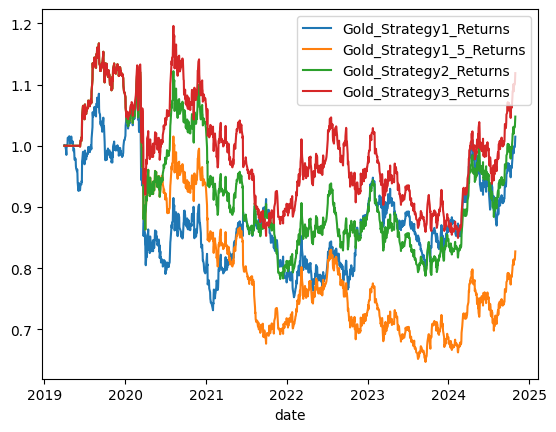

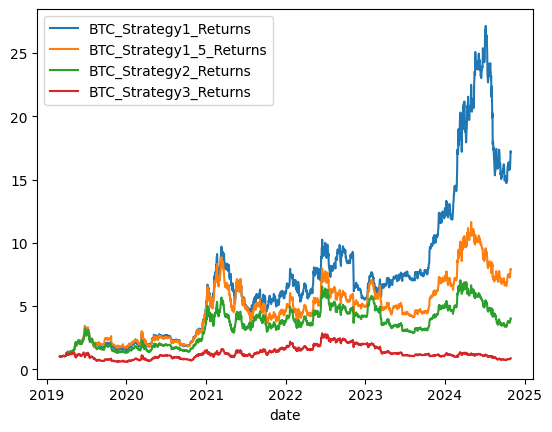

In [157]:
#plot the cumulative returns
gold_cumulative_returns.plot()
btc_cumulative_returns.plot()

In [158]:
#Sharpe
gold_sharpe = gold_all_returns.mean()*np.sqrt(252) / gold_all_returns.std()
btc_sharpe = btc_all_returns.mean() *np.sqrt(365) / btc_all_returns.std()

print(gold_sharpe)
print(btc_sharpe)

Gold_Strategy1_Returns      0.095596
Gold_Strategy1_5_Returns   -0.139426
Gold_Strategy2_Returns      0.131719
Gold_Strategy3_Returns      0.207179
dtype: float64
BTC_Strategy1_Returns      1.090726
BTC_Strategy1_5_Returns    0.881215
BTC_Strategy2_Returns      0.698623
BTC_Strategy3_Returns      0.286722
dtype: float64


In [159]:
#using long only as benchmark
gold_long_only = gold['daily_return']
btc_long_only = btc['daily_return']

#Sharpe
gold_long_only_sharpe = gold_long_only.mean()*np.sqrt(252) / gold_long_only.std()
btc_long_only_sharpe = btc_long_only.mean() *np.sqrt(365) / btc_long_only.std()

print(gold_long_only_sharpe)
print(btc_long_only_sharpe)

0.9414674477506721
1.1040392785630069


### Final thought
The Holt winters model are not really fitted and accurate as the returns are not really stationary distribution.

The accuracy of the Holt winters model largely affect the performance of the strategies, we may further finetune the models or using other prediction model to replace in order to improve result.